In [1]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import get_design_functions_1MW, single_point_design
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc
from lacbox.test import test_data_path
from myteampack import MyHTC
from aero_design_functions import*
from pathlib import Path


In [2]:
def thickness(r_norm, chord_root):
    """Absolute thickness [m] as a function of blade span [m] for 35-m blade"""
    p_edge = [
        9.35996e-8,
        -1.2911e-5,
        7.15038e-4,
        -2.03735e-2,
        3.17726e-1,
        -2.65357,
        10.2616,
    ]  # polynomial coefficients
    t_poly = np.polyval(p_edge, r)  # evaluate polynomial
    t = np.minimum(t_poly, chord_root)  # clip at max thickness
    return t

In [3]:
"""Step 2"""

# Given values
#Former class IA
V_rated_X = 11.4  # m/s
I_rated_X = 0.16
R_X = 89.17  # m

#New Class IIIB
I_rated_Y = 0.14

# Define the system of nonlinear equations
def equations(vars):
    V_rated_Y, R_Y = vars
    eq1 = V_rated_Y - (R_X / R_Y)**(2/3) * V_rated_X
    eq2 = R_Y - ((V_rated_X * (1 + 2 * I_rated_X)) / (V_rated_Y * (1 + 2 * I_rated_Y)))**(2/3) * R_X
    return [eq1, eq2]

# Initial guesses for V_rated_Y and R_Y
initial_guess = [1, 1]

# Solve the system of equations
solution = fsolve(equations, initial_guess)

# Extract the solution
V_rated_Y, R_Y = solution

# Output the results
print(f"R_Y: {R_Y} m")
print(f"V_rated_Y: {V_rated_Y} m/s")

R_Y: 92.52423873190985 m
V_rated_Y: 11.122788574520852 m/s


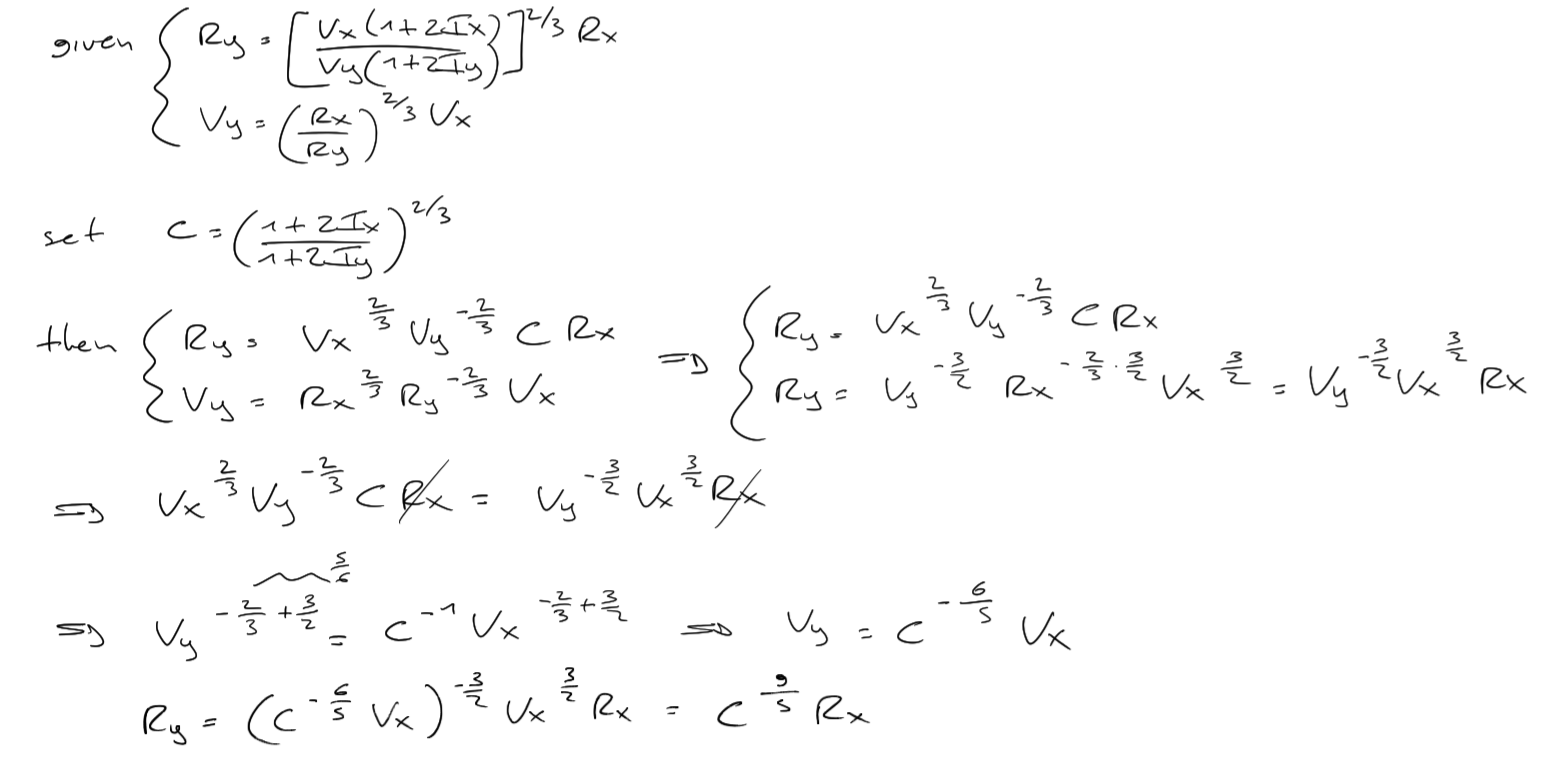

In [4]:
# analytical

V_rated_X = 11.4  # m/s
I_rated_X = 0.16
R_X = 89.17  # m
I_rated_Y = 0.14

C = ((1 + 2 * I_rated_X) / (1 + 2 * I_rated_Y))**(2/3)
R_y_a = C **(9/5) * R_X
V_y_a = C ** (-6/5) *V_rated_X


print(f"R_y_analytical: {R_y_a} m")
print(f"V_y_analytical: {V_y_a} m/s")

R_diff = np.abs(R_Y - R_y_a)/R_Y
V_diff = np.abs(V_rated_Y - V_y_a)/V_rated_Y

print(f"R difference: {R_diff*100}%")
print(f"V difference: {V_diff*100}%")


R_y_analytical: 92.52423873284587 m
V_y_analytical: 11.12278857443654 m/s
R difference: 1.0116553028210895e-09%
V difference: 7.580203512852038e-10%


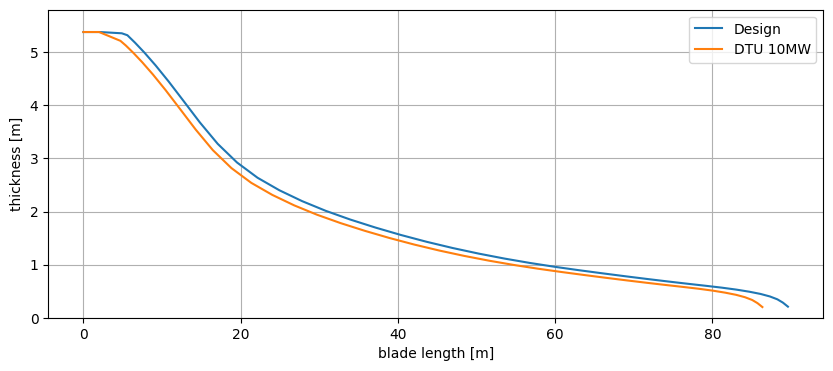

In [5]:
"""Step4"""

# load aerodynamic data
Data_ae = load_ae("DTU_10MW_RWT_ae.dat")

# Data from the DTU 10MW
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }

abs_t_dtu = data_ae["chord"]*data_ae["rel_th"]/100 # dtu thickness
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness

# to force the thickness at the root and make it smoother
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]

#plot the former blade shape and the new one
plt.figure(figsize=(10,4))
plt.plot(data_ae['curve']*R_Y/R_X, abs_t, label='Design')
plt.plot(data_ae['curve'], abs_t_dtu, label='DTU 10MW')
#plt.title("thickness along the blade")
plt.ylim(0,5.8)
plt.xlabel('blade length [m]')
plt.ylabel('thickness [m]')
plt.grid()
plt.legend()
plt.show()


In [6]:
# what does this kernel do?


#Values to make a new htc file

# index, x-coordinate, y-coordinate, z-coordinate, theta
# theta - Angle between local x-axis and main_body x-axis in the main_body x-y coordinate plane. For a straight blade this angle is the aerodynamic twist.

htc = [[1, 0.00000E+00, 7.00600E-05, 4.44089E-16, -1.45000E+01],
[2, -2.06477E-05, -1.22119E-02, 3.00000E+00, -1.45000E+01], 
[3, -7.28810E-03, -2.49251E-02, 6.00000E+00, -1.44851E+01],
[4, -1.89235E-02, -2.73351E-02, 7.00004E+00, -1.44610E+01], 
[5,-5.41282E-02,-2.82163E-02,8.70051E+00,-1.43388E+01], 
[6, -1.26633E-01, -2.13210E-02, 1.04020E+01, -1.40201E+01], 
[7, -2.25666E-01, -1.28378E-02, 1.22046E+01, -1.33904E+01], 
[8, -2.88563E-01, -7.70659E-03, 1.32065E+01, -1.29371E+01], 
[9, -3.99194E-01, -4.88317E-03, 1.50100E+01, -1.19445E+01], 
[10, -5.76634E-01, -1.80296E-02, 1.82151E+01, -9.98243E+00], 
[11, -7.07136E-01, -5.01772E-02, 2.14178E+01, -8.45147E+00], 
[12, -7.91081E-01, -9.41228E-02, 2.46189E+01, -7.46417E+00], 
[13, -8.37195E-01, -1.48880E-01, 2.78193E+01, -6.72916E+00], 
[14, -8.53948E-01, -2.14514E-01, 3.10194E+01, -6.08842E+00], 
[15, -8.49367E-01, -2.90618E-01, 3.42197E+01, -5.49322E+00], 
[16, -7.93920E-01, -4.62574E-01, 4.02204E+01, -4.39222E+00], 
[17, -7.16284E-01, -6.88437E-01, 4.66217E+01, -3.09315E+00], 
[18, -6.34358E-01, -9.60017E-01, 5.30232E+01, -1.75629E+00], 
[19, -5.53179E-01, -1.28424E+00, 5.94245E+01, -5.00650E-01], 
[20, -4.75422E-01, -1.66402E+00, 6.58255E+01, 6.01964E-01], 
[21, -4.03180E-01, -2.10743E+00, 7.22261E+01, 1.55560E+00], 
[22, -3.30085E-01, -2.65630E+00, 7.90266E+01, 2.51935E+00], 
[23, -3.10140E-01, -2.78882E+00, 8.05267E+01, 2.72950E+00], 
[24, -2.86719E-01, -2.92517E+00, 8.20271E+01, 2.93201E+00], 
[25, -2.55823E-01, -3.06577E+00, 8.35274E+01, 3.11874E+00], 
[26, -2.07891E-01, -3.20952E+00, 8.50277E+01, 3.28847E+00], 
[27, -8.98940E-02, -3.33685E+00, 8.63655E+01, 3.42796E+00]]

new_center_line_htc = np.array(htc)

new_center_line_htc[:,3]=new_center_line_htc[:,3]*R_Y/R_X

print(new_center_line_htc[0])

[ 1.00000000e+00  0.00000000e+00  7.00600000e-05  4.60793951e-16
 -1.45000000e+01]


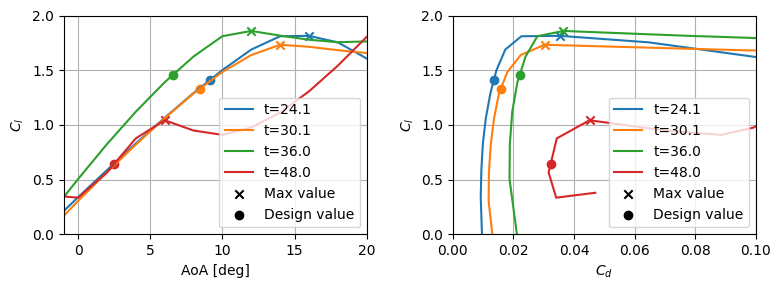

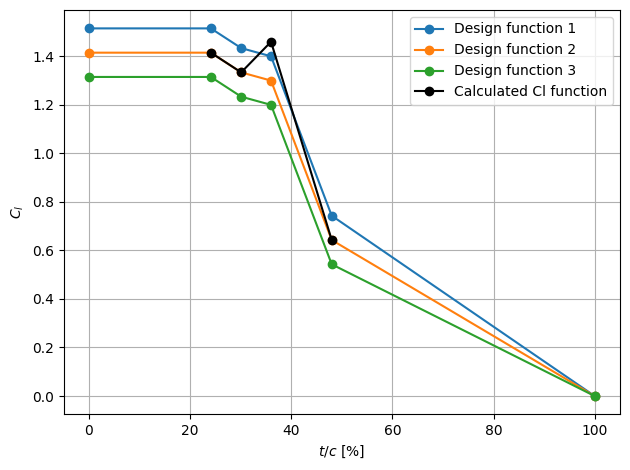

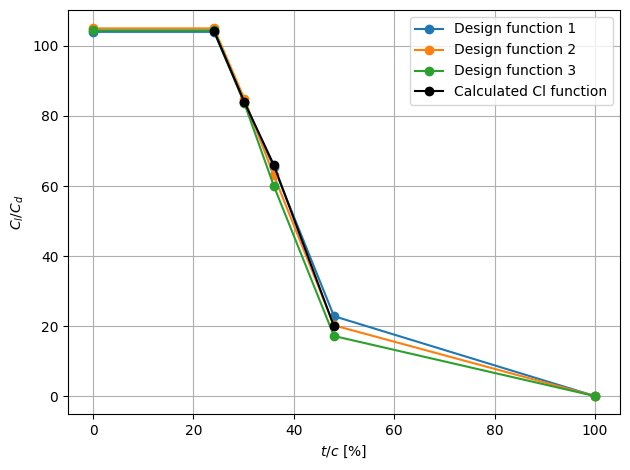

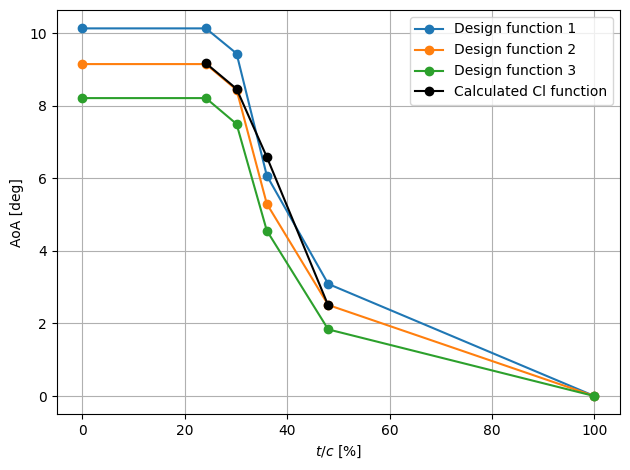

In [7]:
"""Step 6"""
"""I started working here
My goal was to use the data that we have from the 10MW pc.dat file for the cl and cd and alpha to determine for each type of blade what what the cl, cd and aoa at the maximum cl/cd
Then generate a function get_design_functions_10MW() that will take into consideration those values in order to get the cl cd and aoa designed 
and then plot everything using the previous method view in the exercice of week 3
BUT THE PLOTS ARE A BIT WEIRD please have a look"""
import numpy as np
import matplotlib.pyplot as plt

# Assuming the functions load_pc() and get_design_functions() are defined elsewhere

# Define a cl plot for the 10MW using the pc.dat
Data_cl = load_pc("DTU_10MW_RWT_pc.dat") # return a list per blade
n = len(Data_cl)-2 # exclude airfoils of 100% and 60% relative thickness
des_param = np.zeros((4,n)) # relative thickness, cl design, cd design, AoA design
arg_0 = [63,63,63,58] # indices of the AoAs before stall

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# Plot 1: AoA vs Cl with max and design points
for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.4

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    cd_max = Data_cl[k]["cd"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]

    # Plot AoA vs Cl on the first subplot
    line, = ax[0].plot(Data_cl[k]["aoa_deg"], Data_cl[k]["cl"], label=f"t={des_param[0,k]}")
    ax[0].scatter(aoa_des, cl_des, marker="o", color=line.get_color())
    ax[0].scatter(aoa_max, cl_max, marker="x", color=line.get_color())

    # Plot AoA vs Cl on the first subplot
    line, = ax[1].plot(Data_cl[k]["cd"][50:arg_0[k]+10], Data_cl[k]["cl"][50:arg_0[k]+10], label=f"t={des_param[0,k]}")
    ax[1].scatter(cd_des, cl_des, marker="o", color=line.get_color())
    ax[1].scatter(cd_max, cl_max, marker="x", color=line.get_color())

# Customize the first subplot
ax[0].scatter([], [], marker="x", color="black", label="Max value")
ax[0].scatter([], [], marker="o", color="black", label="Design value")
ax[0].set_xlim(-1, 20)
ax[0].set_ylim(0, 2)
ax[0].set_xlabel('AoA [deg]')
ax[0].set_ylabel('$C_l$')
ax[0].legend()
ax[0].grid()

# Plot 2: Cl vs Cd with design functions
# Customize the first subplot
ax[1].scatter([], [], marker="x", color="black", label="Max value")
ax[1].scatter([], [], marker="o", color="black", label="Design value")
ax[1].set_xlim(0, 0.1)
ax[1].set_ylim(0, 2)
ax[1].set_xlabel('$C_d$')
ax[1].set_ylabel('$C_l$')
ax[1].legend()
ax[1].grid()
# Show the plots
plt.tight_layout()
plt.show()


for i in range(1, 4):
    _, _, _, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(i)
    plt.plot(tc_vals, cl_vals, marker='o', label=f"Design function {i}")

# Plot thickness versus CL max
plt.plot(des_param[0,:], des_param[1,:], marker='o', color='k', label="Calculated Cl function")
plt.xlabel('${t/c}$ [%]')
plt.ylabel('$C_l$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

for i in range(1, 4):
    _, _, _, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(i)
    plt.plot(tc_vals, cl_vals/cd_vals, marker='o', label=f"Design function {i}")

# Plot thickness versus CL/CD max
plt.plot(des_param[0,:], des_param[1,:]/des_param[2,:], marker='o', color='k', label="Calculated Cl function")
plt.xlabel('${t/c}$ [%]')
plt.ylabel('$C_l/C_d$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

for i in range(1, 4):
    _, _, _, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(i)
    plt.plot(tc_vals, aoa_vals, marker='o', label=f"Design function {i}")

# Plot thickness versus CL max
plt.plot(des_param[0,:], des_param[3,:], marker='o', color='k', label="Calculated Cl function")
plt.xlabel('${t/c}$ [%]')
plt.ylabel('AoA [deg]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


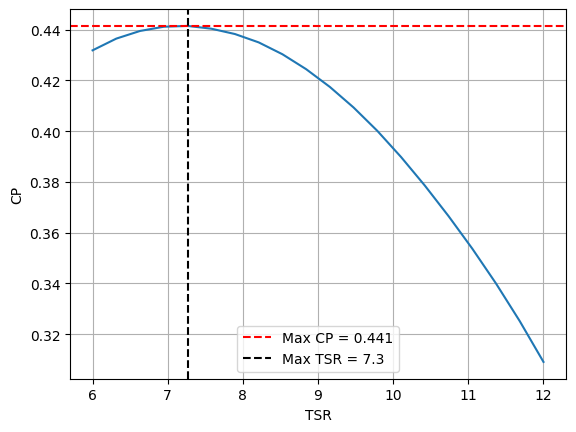

In [8]:
"""Step 7"""

# %% Inputs
R = R_Y  # Rotor radius [m]
r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R - 0.1, 40)  # Rotor span [m]
chord_root = 5.38  # Chord size at the root [m]
chord_max = 6.3  # Maximum chord size [m]
#chord_max = np.amax(abs_t)/(np.amax(des_param[0,:])/100) # Maximum chord size [m] 
"""BE CAREFUL HOW TO CHOOSE CHORD MAX"""
t = abs_t # Absolute thickness [m]
B = 3  # Number of blades [#]
# Aero dynamic polar design functions and the values (t/c vs. cl, cd, aoa)
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)

TSR = np.linspace(6,12,20)
chord_max_list = [6.3]

for chord_max in chord_max_list:
    CP_list =[]

    for tsr in TSR:
        # %% Solving for the a single design
        chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
            r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
        CP_list.append(CP)

    plt.plot(TSR,CP_list)

CP_max=np.amax(CP_list)
TSR_max=TSR[np.argmax(CP_list)]

plt.axhline(CP_max, label = f'Max CP = {CP_max:.3f}',linestyle='--', color='red')
plt.axvline(TSR_max, label = f'Max TSR = {TSR_max:.1f}',linestyle='--', color='k')
plt.xlabel("TSR")
plt.ylabel('CP')
plt.legend()
plt.grid()
plt.show()


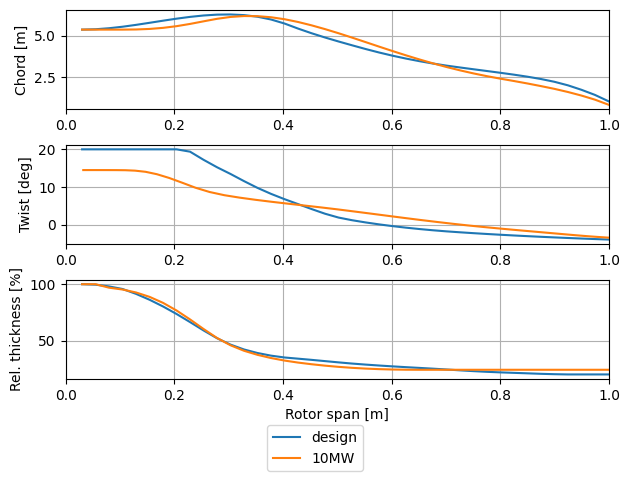

In [9]:
"""Step 8"""

tsr = TSR_max  # Tip-Speed-Ratio [-]

# %% Solving for the a single design
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B
)

"""Data 10MW"""
twist_10MW = np.array([ 0.253095  ,  0.253104  ,  0.253113  ,  0.253115  ,  0.253106  ,
        0.253088  ,  0.253019  ,  0.252883  ,  0.25241   ,  0.250469  ,
        0.245123  ,  0.23393   ,  0.216861  ,  0.195114  ,  0.171519  ,
        0.151683  ,  0.136897  ,  0.125664  ,  0.115773  ,  0.1066    ,
        0.0978849 ,  0.0891832 ,  0.0804282 ,  0.0711842 ,  0.0613002 ,
        0.0512906 ,  0.0412496 ,  0.031342  ,  0.0218855 ,  0.0129861 ,
        0.00460966, -0.00305632, -0.00991266, -0.0161097 , -0.0218838 ,
       -0.0271989 , -0.0321248 , -0.0367266 , -0.0409807 , -0.0448672 ,
       -0.0483542 , -0.0513391 , -0.0537827 , -0.0557309 , -0.0572525 ,
       -0.0583948 , -0.0591894 , -0.0596566 ])*180/np.pi

r_10MW = (np.array([ 0.08883 ,  0.354955,  0.797281,  1.41399 ,  2.20255 ,  3.15971 ,
        4.28156 ,  5.56347 ,  7.00025 ,  8.58585 , 10.3137  , 12.177   ,
       14.1679  , 16.2782  , 18.4993  , 20.822   , 23.2369  , 25.7339  ,
       28.3028  , 30.9331  , 33.6139  , 36.3343  , 39.083   , 41.8488  ,
       44.6202  , 47.386   , 50.1347  , 52.8551  , 55.5359  , 58.1662  ,
       60.7352  , 63.2321  , 65.647   , 67.9697  , 70.1908  , 72.3012  ,
       74.2921  , 76.1554  , 77.8833  , 79.4689  , 80.9056  , 82.1875  ,
       83.3093  , 84.2666  , 85.0551  , 85.6716  , 86.1141 , 86.3804])+r_hub)/R_X


r_norm=r/R_Y


fig2, axs2 = plt.subplots(3, 1, num=2, clear=True)

# Chord
axs2[0].plot(r_norm, chord,label="design")
axs2[0].plot(r_norm, data_ae["chord"],label="10MW")
axs2[0].set_ylabel("Chord [m]")
axs2[0].set_xlim(0, R/R_Y)
axs2[0].grid(True)

# Twist
axs2[1].plot(r_norm, twist)
axs2[1].plot(r_10MW, twist_10MW)
axs2[1].set_ylabel("Twist [deg]")
axs2[1].set_xlim(0, R/R_Y)
axs2[1].grid(True)

# t/c
axs2[2].plot(r_norm, tc)
axs2[2].plot(r_norm, data_ae["rel_th"])
axs2[2].set_ylabel("Rel. thickness [%]")
axs2[2].set_xlabel("Normalised Rotor span")
axs2[2].set_xlim(0, R/R_Y)
axs2[2].grid(True)

axs2[2].set_xlabel("Rotor span [m]")

fig2.tight_layout()
fig2.subplots_adjust(bottom=0.2)
fig2.legend(loc='lower center')

plt.show()

In [10]:
'''

"""Step 8"""

tsr = TSR_max  # Tip-Speed-Ratio [-]

# %% Solving for the a single design
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B
)

"""Data 10MW"""
twist_10MW = np.array([ 0.253095  ,  0.253104  ,  0.253113  ,  0.253115  ,  0.253106  ,
        0.253088  ,  0.253019  ,  0.252883  ,  0.25241   ,  0.250469  ,
        0.245123  ,  0.23393   ,  0.216861  ,  0.195114  ,  0.171519  ,
        0.151683  ,  0.136897  ,  0.125664  ,  0.115773  ,  0.1066    ,
        0.0978849 ,  0.0891832 ,  0.0804282 ,  0.0711842 ,  0.0613002 ,
        0.0512906 ,  0.0412496 ,  0.031342  ,  0.0218855 ,  0.0129861 ,
        0.00460966, -0.00305632, -0.00991266, -0.0161097 , -0.0218838 ,
       -0.0271989 , -0.0321248 , -0.0367266 , -0.0409807 , -0.0448672 ,
       -0.0483542 , -0.0513391 , -0.0537827 , -0.0557309 , -0.0572525 ,
       -0.0583948 , -0.0591894 , -0.0596566 ])*180/np.pi

r_10MW = (np.array([ 0.08883 ,  0.354955,  0.797281,  1.41399 ,  2.20255 ,  3.15971 ,
        4.28156 ,  5.56347 ,  7.00025 ,  8.58585 , 10.3137  , 12.177   ,
       14.1679  , 16.2782  , 18.4993  , 20.822   , 23.2369  , 25.7339  ,
       28.3028  , 30.9331  , 33.6139  , 36.3343  , 39.083   , 41.8488  ,
       44.6202  , 47.386   , 50.1347  , 52.8551  , 55.5359  , 58.1662  ,
       60.7352  , 63.2321  , 65.647   , 67.9697  , 70.1908  , 72.3012  ,
       74.2921  , 76.1554  , 77.8833  , 79.4689  , 80.9056  , 82.1875  ,
       83.3093  , 84.2666  , 85.0551  , 85.6716  , 86.1141 , 86.3804])+r_hub)/R_X


tc_plot = np.linspace(0, 100, 100)
fig1, axs1 = plt.subplots(3, 1, num=1)

axs1[0].plot(tc_plot, cl_des(tc_plot), "k")
axs1[0].plot(tc_vals, cl_vals, "ok")
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 100)

axs1[1].plot(tc_plot, cd_des(tc_plot), "k")
axs1[1].plot(tc_vals, cd_vals, "ok")
axs1[1].set_ylabel("$C_d$ [-]")
axs1[1].set_xlim(0, 100)

axs1[2].plot(tc_plot, aoa_des(tc_plot), "k")
axs1[2].plot(tc_vals, aoa_vals, "ok")
axs1[2].set_ylabel(r"$\alpha$ [-]")
axs1[2].set_xlabel(r"$t/c$ [deg]")
axs1[2].set_xlim(0, 100)

fig1.tight_layout()

# %% Plot the chord, twist and relative-thickness
fig2, axs2 = plt.subplots(3, 1, num=2, clear=True)

r_norm=r/R_Y
# Chord
axs2[0].plot(r_norm, chord,label="design")
axs2[0].plot(r_norm, data_ae["chord"],label="10MW")
axs2[0].set_ylabel("Chord [m]")
axs2[0].set_xlim(0, R/R_Y)

# Twist
axs2[1].plot(r_norm, twist)
axs2[1].plot(r_10MW, twist_10MW)
axs2[1].set_ylabel("Twist [deg]")
axs2[1].set_xlim(0, R/R_Y)

# t/c
axs2[2].plot(r_norm, tc)
axs2[2].plot(r_norm, data_ae["rel_th"])
axs2[2].set_ylabel("Rel. thickness [%]")
axs2[2].set_xlabel("Normalised Rotor span")
axs2[2].set_xlim(0, R/R_Y)

fig2.legend()
fig2.tight_layout()

# %% Plot r vs. t/c, aoa, cl, cd
fig3, axs3 = plt.subplots(2, 2, num=3, clear=True)

# t/c
axs3[0, 0].plot(r, tc)
axs3[0, 0].set_ylabel("t/c [%]")
axs3[0, 0].set_xlim(0, R)

# aoa
axs3[0, 1].plot(r, aoa)
axs3[0, 1].set_ylabel(r"$\alpha$ [deg]")
axs3[0, 1].set_xlim(0, R)
axs3[0, 1].yaxis.tick_right()
axs3[0, 1].yaxis.set_label_position("right")

# cl
axs3[1, 0].plot(r, cl)
axs3[1, 0].plot(r_redesign, Cl_redesign)
axs3[1, 0].set_ylabel("$C_l$ [-]")
axs3[1, 0].set_xlabel("Span [m]")
axs3[1, 0].set_xlim(0, R)

# cd
axs3[1, 1].plot(r, cd)
axs3[1, 1].set_ylabel("$C_d$ [-]")
axs3[1, 1].set_xlabel("Span [m]")
axs3[1, 1].set_xlim(0, R)
axs3[1, 1].yaxis.tick_right()
axs3[1, 1].yaxis.set_label_position("right")

fig3.tight_layout()

# %% Plot r vs. CLT, CLP, a
fig4, axs4 = plt.subplots(3, 1, num=4, clear=True, figsize=(6.5, 5.5))

# Local-Thrust-Coefficient
axs4[0].plot(r, CLT, label="1*thickness")
axs4[0].axhline(y=8 / 9, ls="--", color="k", lw=1)
axs4[0].set_ylabel("Local thrust ($C_{LT}$) [-]")
axs4[0].set_ylim(0, 1.0)
axs4[0].set_xlim(0, R)


# Local-Power-Coefficient
axs4[1].plot(r, CLP)
axs4[1].axhline(y=16 / 27, ls="--", color="k", lw=1)
axs4[1].set_ylabel("Local Power ($C_{LP}$) [-]")
axs4[1].set_xlim(0, R)
axs4[1].set_ylim(-0.4, 0.6)

# Axial Induction
axs4[2].plot(r, a)
axs4[2].axhline(y=1 / 3, ls="--", color="k", lw=1)
axs4[2].set_ylabel("Axial induction ($a$) [-]")
axs4[2].set_xlabel("Rotor span [m]")
axs4[2].set_xlim(0, R)

fig4.legend()
fig4.suptitle(f"$C_T$={CT:1.3f}, $C_P$={CP:1.3f}")#, $C_T_Rel_Thi$={CT1:1.3f}, $C_P_Rel_Thi$={CP1:1.3f}")
fig4.tight_layout()

plt.show()
'''

'\n\n"""Step 8"""\n\ntsr = TSR_max  # Tip-Speed-Ratio [-]\n\n# %% Solving for the a single design\nchord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(\n    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B\n)\n\n"""Data 10MW"""\ntwist_10MW = np.array([ 0.253095  ,  0.253104  ,  0.253113  ,  0.253115  ,  0.253106  ,\n        0.253088  ,  0.253019  ,  0.252883  ,  0.25241   ,  0.250469  ,\n        0.245123  ,  0.23393   ,  0.216861  ,  0.195114  ,  0.171519  ,\n        0.151683  ,  0.136897  ,  0.125664  ,  0.115773  ,  0.1066    ,\n        0.0978849 ,  0.0891832 ,  0.0804282 ,  0.0711842 ,  0.0613002 ,\n        0.0512906 ,  0.0412496 ,  0.031342  ,  0.0218855 ,  0.0129861 ,\n        0.00460966, -0.00305632, -0.00991266, -0.0161097 , -0.0218838 ,\n       -0.0271989 , -0.0321248 , -0.0367266 , -0.0409807 , -0.0448672 ,\n       -0.0483542 , -0.0513391 , -0.0537827 , -0.0557309 , -0.0572525 ,\n       -0.0583948 , -0.0591894 , -0.0596566 ])*180/np.pi\n\nr_